<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial_for_SMT_based_Verification_with_Z3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for SMT based Neural Network Verification with Z3

---

*As an example we try to verifiy the **robustness** of a classification Network trained on the iris dataset. We learn how to train a small neural network in pytorch and use the weights and biases to create a number of terms and formulas.*

---

Because of the focus of this tutorial we don't go into details about the data pre processing and training. If you are interested in that part you can look into the training code for this tutorial at [Iris_Trainer](https://github.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/lib/iris_trainer.py) or other tutorials like this [Pytorch Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py).


Before building our neural network verification, we have to import the necessary packages. For the sake of readability we put helper functions for the import of the dataset as well as plotting into the iris_trainer and plots libraries. We also import z3 for our SMT-solver, torch for our neural network learning, numpy for our calculations and time for the purpose of benchmarking.

In [ ]:
%%capture

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/iris_trainer.py'}
import iris_trainer

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/plots.py'}
import plots

# SMT solver
%pip install z3-solver
from z3 import *

from torch import nn
import numpy as np
import time

<a id='header_training'></a>
## Training of Neural Network
To verify the robustness of a neural network, we first have to train our neural network. To this end we create a neural network with an input layer, a hidden layer with ReLu as its activation function and an output layer.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

After initializing the ANN, load the dataset and use the dataset as an input to train the model.

In [ ]:
names, feature_names, X, y, X_scaled, X_train, X_test, y_train, y_test = iris_trainer.load_dataset()

model = iris_trainer.train_model(
    NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=5), 
    epochs=100, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0
Shape of training set X (120, 4)
Shape of test set X (30, 4)


100%|██████████| 100/100 [00:00<00:00, 333.24it/s]


Done. Accuracy: 0.7333333333333333


We can now plot the test dataset with its correct predictions and the predictions of our trained neural network.

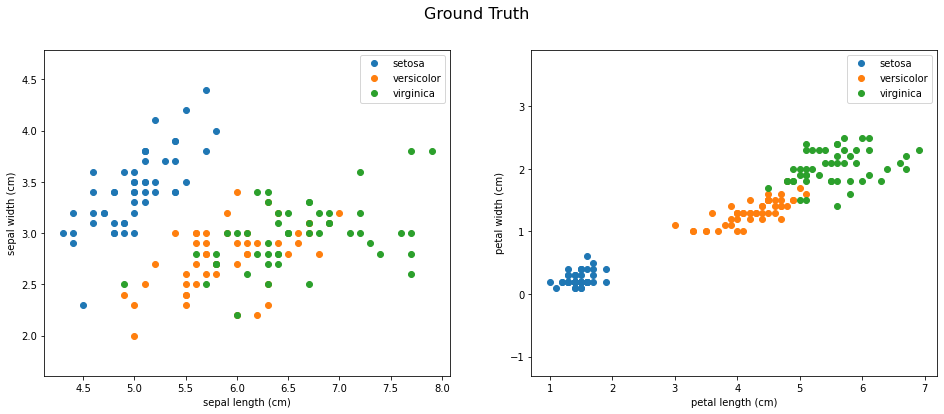

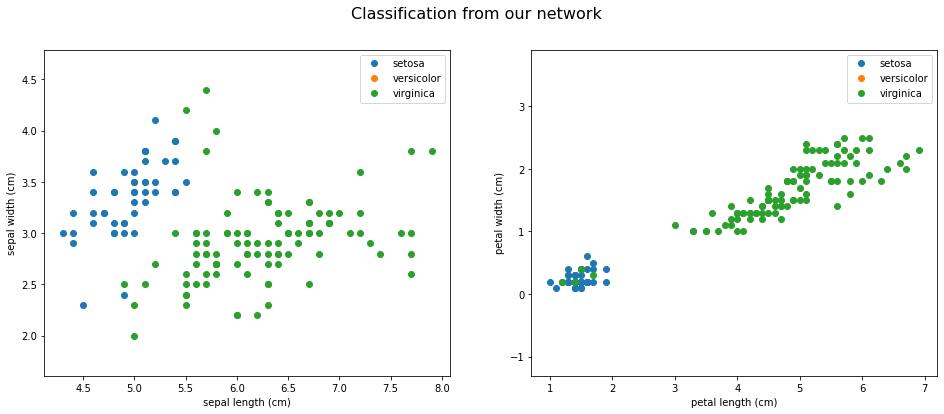

In [ ]:
plots.show_plots(names, feature_names, X, y, title = 'Ground Truth')
plots.show_plots(names, feature_names, X, iris_trainer.predict(X_scaled, model), title = 'Classification from our network')

## Define Coditions for Robustness

To check the robustness we need to define a procondition and a postcondition. 
The precondition defines a condition for an testsample. In our case that means that a given point $x$ has a pertubation $c$ with an distance of epsilon $ϵ$, so that:

$$
precondition: || x - c || \leq  \epsilon
$$

The postcondition now checks if the class of the output $r$ is the same in the pertubated sample as the label $y$:

$$
postcondition: class(r) = y
$$

The complete verification condition for a neural network $f(x)$ states:

$$
precondition ∧ f(x) \Rightarrow postcondition
$$

After training our models in the last section we can begin with checking its robustness. Therefore we will choose a fixed element $x$ from the test dataset and an epsilon $ϵ$ for which we will check the robustness. 
We check if there exists an element $c$ with a maximum difference $\epsilon$ to $x$, for which the classification is wrong.

### Precondition : $|| x - c || \leq \epsilon$



For the precondition we choose an element from the test dataset and extract its class. Then we also set an epsilon.

In [ ]:
fixed_input_y = X_scaled[0]
fixed_input_y_class = y[0]
epsilon = 0.1

We can plot our data with a box of for epsilon around our chosen element.

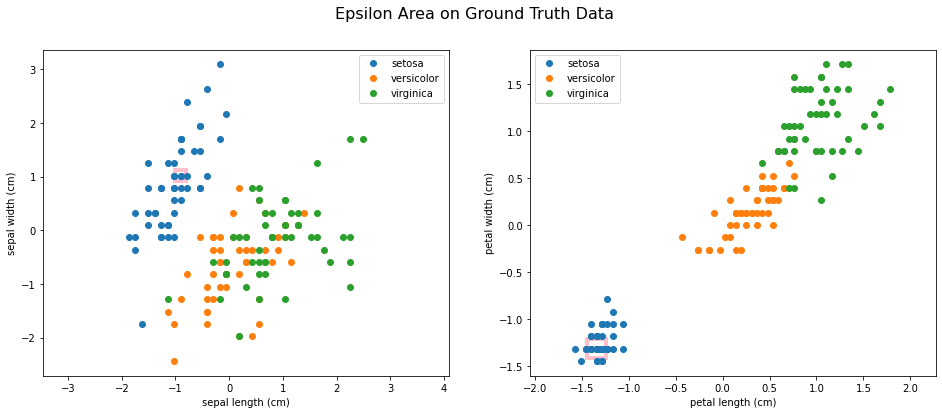

In [ ]:
plots.show_plots(names, feature_names, X_scaled, y, fixed_input_y, epsilon, title = 'Epsilon Area on Ground Truth Data')

To calculate a counterexample to the robustness, we create a vector of Type Real for our misclassified example with z3. Then we conjunct constraints about the difference of our fixed input and the misclassified example to work as our precondition.

In [ ]:
input_size = fixed_input_y.shape[0]
x = RealVector("x", input_size)

def create_pre_condition():
  and_parts = []
  for i, x_vi in enumerate(x):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  return And(and_parts)

pre_cond = create_pre_condition()

We can now print our precondition to see, that our misclassified example is still only consisting of symbolic variables, as we haven't used z3 to search for a model of our constraint system.

In [ ]:
print(pre_cond)

And(And(x__0 - -9006811702978099/10000000000000000 <= 1/10,
        -9006811702978099/10000000000000000 - x__0 <= 1/10),
    And(x__1 - 2038008703943213/2000000000000000 <= 1/10,
        2038008703943213/2000000000000000 - x__1 <= 1/10),
    And(x__2 - -2680453053245527/2000000000000000 <= 1/10,
        -2680453053245527/2000000000000000 - x__2 <= 1/10),
    And(x__3 - -13154442950077407/10000000000000000 <= 1/10,
        -13154442950077407/10000000000000000 - x__3 <= 1/10))


### Postcondition: $class(r) = y$

For our postcondition we can ask that our biased input is still classified with the same label as our fixed input. For that all other outputs must be smaller or equal than the correct label.

In [ ]:
model_parameters = [param.cpu().detach().numpy() for param in model.parameters()]
weights = model_parameters[0::2]
output  = [RealVector(f"x{i}", weight.shape[0]) for i, weight in enumerate(weights)]

In [ ]:
# post-condition
# x_vo = x_v'
and_parts = []
for i, x_vo in enumerate(output[-1]):
  # l is the argmax of fixed_input_y
  and_parts.append(x_vo <= output[-1][fixed_input_y_class])
post_cond = And(and_parts)

In [ ]:
print(post_cond)

And(x1__0 <= x1__0, x1__1 <= x1__0, x1__2 <= x1__0)


## Defining the Assignment

Next we create a solver in order to find Aversarial Examples. "An adversarial example is an instance with small, intentional feature perturbations that cause a machine learning model to make a false prediction." (For more information on adversarial examples see [this article](https://christophm.github.io/interpretable-ml-book/adversarial.html)).

We use Z3 in this Tutorial. Z3 is a theorem prover from Microsoft Research (for more information on z3 see [z3 on pypi](https://pypi.org/project/z3-solver/)). 

The ML model was trained on the iris dataset in the previous section. Now we recreate the model using the trained weights and the layers of the model.

---

We start with extracting the learned weights and biases from the model. This is done by iterating over the layers and saving the weights and biases of the Linear Layers into lists.

In [ ]:
model_parameters = [param.cpu().detach().numpy() for param in model.parameters()]
weights = model_parameters[0::2]
biases = model_parameters[1::2]

The ReLu Function for a single neuron is encoded in z3 with an If condition for the value of the input.

In [ ]:
def ReluSingleNeuron(x):
  return If(x >= 0, x, RealVal(0))

We can now model the function of our neural network by computing the output of each neuron symbolically and adding the input output relation constraints to our set of constraints as an assign part.

In [ ]:
# assign
assign_parts = []
# for each layer
for layer_i, (layer_output, layer_weights, layer_biases) in enumerate(zip(output, weights, biases)):
  # for each neuron
  for neuron_output, neuron_weights, neuron_bias in zip(layer_output, layer_weights, layer_biases):
    if layer_i == 0:
      # neuron input is net input
      neuron_inputs = x
    else:
      # neuron input is output of previous layer
      neuron_inputs = output[layer_i - 1]
    assign_parts.append(neuron_output == ReluSingleNeuron(neuron_weights @ neuron_inputs + neuron_bias))
assign = And(assign_parts)

We then print out our assign part again sybolically.

In [ ]:
print(assign_parts[0])

x0__0 ==
If(11655760556459427/50000000000000000*x__0 +
   304679274559021/1000000000000000*x__1 +
   -11251679062843323/100000000000000000*x__2 +
   -12592554092407227/100000000000000000*x__3 +
   -6632803/20000000 >=
   0,
   11655760556459427/50000000000000000*x__0 +
   304679274559021/1000000000000000*x__1 +
   -11251679062843323/100000000000000000*x__2 +
   -12592554092407227/100000000000000000*x__3 +
   -6632803/20000000,
   0)


## Verifying robustness

The verification condition for our neural network is obtained from our precondition, our assign constraints and our postcondition.
The verification condition is then given to the SMT-Solver and the validity proven.

In [ ]:
# verification conditions
verification_cond = Implies(And(pre_cond, assign), post_cond)

# prove using Z3
solver = Solver()
solver.add(Not(verification_cond))
if solver.check() == unsat:
  print("proved")
else:
  print("failed to prove")

failed to prove


If you want a counterexample you can use the build in prove function from Z3.

In [ ]:
prove(verification_cond)

### Binary search for upper epsilon
Until now we chose our epsilon freely. But maybe we want to search for an upper epsilon, where our condition does not hold. This can be easily achieved by creating the following function. In this function we recreate the verification condition and solve it. Just like we did before in this tutorial.

In [ ]:
def prove_for_epsilon():
  start_time = time.time()
  pre_cond = create_pre_condition()
  verification_cond = Implies(And(pre_cond, assign), post_cond)
  solver = Solver()
  solver.add(Not(verification_cond))
  result = solver.check()
  print(f"{((time.time() - start_time)/60):.4f} minutes of solving time")
  if result == unsat:
    return True
  else:
    return False

Now we can change our epsilon and easiyl try to prove the robustness based on that value.

In [ ]:
epsilon = 0.6
prove_for_epsilon()

0.0037 minutes


False

Now we can use binary search to find an approximation of the upper bound for epsilon.

0.0029 minutes of solving time
Proven for epsilon = 0.0002  Doubling epsilon.
0.0057 minutes of solving time
Proven for epsilon = 0.0004  Doubling epsilon.
0.0029 minutes of solving time
Proven for epsilon = 0.0008  Doubling epsilon.
0.0019 minutes of solving time
Proven for epsilon = 0.0016  Doubling epsilon.
0.0016 minutes of solving time
Proven for epsilon = 0.0032  Doubling epsilon.
0.0020 minutes of solving time
Proven for epsilon = 0.0064  Doubling epsilon.
0.0015 minutes of solving time
Proven for epsilon = 0.0128  Doubling epsilon.
0.0016 minutes of solving time
Proven for epsilon = 0.0256  Doubling epsilon.
0.0017 minutes of solving time
Proven for epsilon = 0.0512  Doubling epsilon.
0.0029 minutes of solving time
Proven for epsilon = 0.1024  Doubling epsilon.
0.0034 minutes of solving time
Proven for epsilon = 0.2048  Doubling epsilon.
0.0045 minutes of solving time
Proven for epsilon = 0.4096  Doubling epsilon.
0.0051 minutes of solving time
Could not be proven for epsilon =

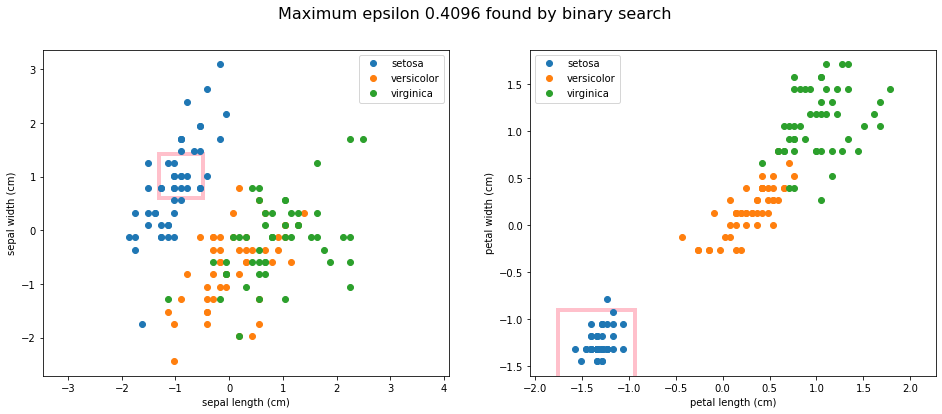

In [ ]:
epsilon = 0.0002;
while prove_for_epsilon():
  print("Proven for epsilon =", epsilon," Doubling epsilon.")
  epsilon *= 2
print("Could not be proven for epsilon =", epsilon)
plots.show_plots(names, feature_names, X_scaled, y, fixed_input_y, epsilon/2, title = f'Maximum epsilon {epsilon/2} found by binary search')

# Tip

TIP: This verification could take a long time depending on how big your network is. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```
Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!